In [69]:
import os
import cv2
import pandas as pd
from keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [70]:
model = load_model('modelV9.h5')

In [71]:
testset_folder = "Dataset/testset"

img_size = 64
input_shape = (img_size, img_size, 3)

map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
                  3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
                  7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
                  11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
                  14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

reverse_map_characters = {v: k for k, v in map_characters.items()}

In [72]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    img = cv2.resize(image, (64, 64)).astype('float32') / 255
    return img

In [73]:
testset = pd.DataFrame()

rows = []

for img_file in os.listdir(testset_folder):
    img_path = os.path.join(testset_folder, img_file)
    img = load_and_preprocess_image(img_path)

    file_parts = img_file.split('_')
    character_name_parts = file_parts[:-1]
    character_name = '_'.join(character_name_parts)

    try:
        label = reverse_map_characters[character_name]
    except:
        continue

    row_df = pd.DataFrame({'path': [img_path], 'label': [label], 'image': [img]})
    rows.append(row_df)

testset = pd.concat(rows, ignore_index=True)

In [74]:
test_data = np.array(testset['image'].tolist())
true_labels = np.array(testset['label'])

true_labels = to_categorical(true_labels, len(map_characters))

print(f'Reshaping test data to: {test_data.shape[0],img_size,img_size,3}')

test_data = test_data.reshape(test_data.shape[0],img_size,img_size,3)

Reshaping test data to: (890, 64, 64, 3)


In [75]:
predicted_probabilities = model.predict(test_data)

predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels_one_hot = to_categorical(predicted_labels, len(map_characters))


accuracy = accuracy_score(true_labels, predicted_labels_one_hot)

print(f'Accuracy on test set: {accuracy * 100:.2f}%')

28/28 [==============================] - 1s 24ms/step
Accuracy on test set: 87.08%


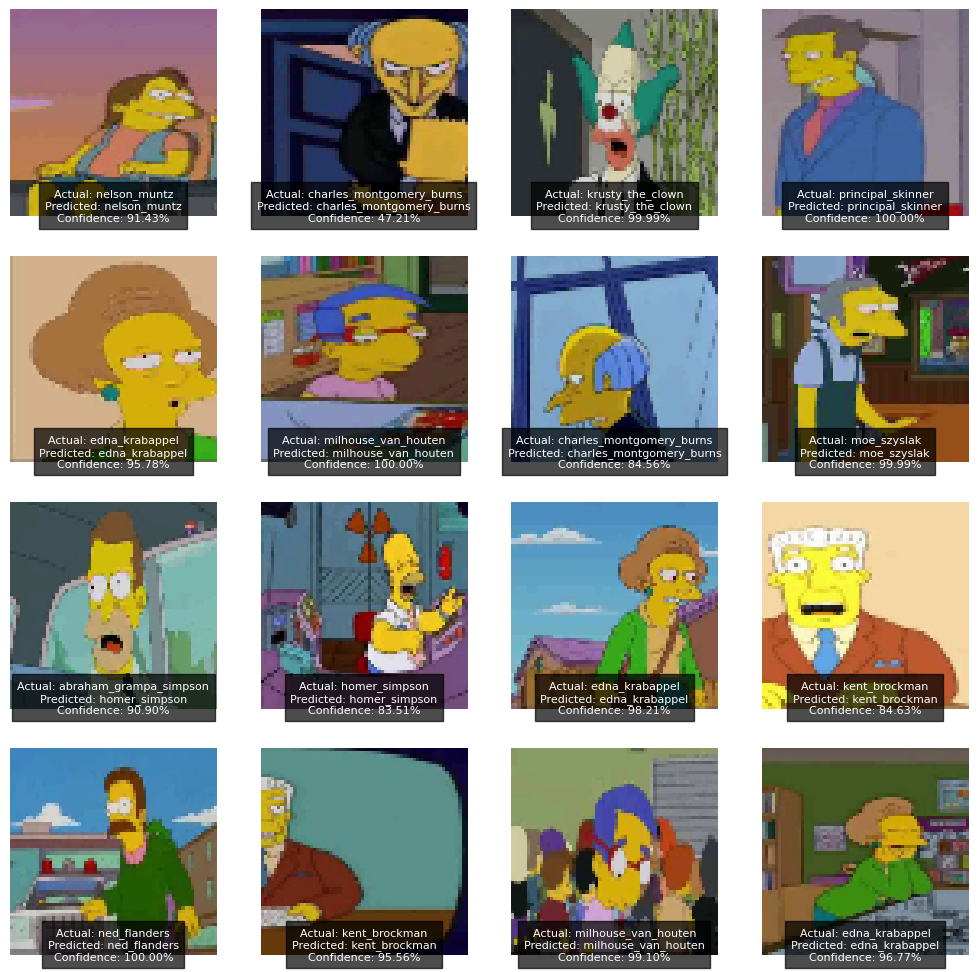

In [76]:
sample_indices = random.sample(range(len(test_data)), 16)
sample_images = test_data[sample_indices]
sample_true_labels = true_labels[sample_indices]
sample_predicted_labels = predicted_labels[sample_indices]
sample_confidences = np.max(predicted_probabilities[sample_indices], axis=1) * 100

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = sample_images[i]
    font = cv2.FONT_HERSHEY_SIMPLEX
    actual_character = map_characters[np.argmax(sample_true_labels[i])]
    predicted_character = map_characters[sample_predicted_labels[i]]
    confidence = sample_confidences[i]

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

    text = f'Actual: {actual_character}\nPredicted: {predicted_character}\nConfidence: {confidence:.2f}%'
    ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=8, color='white', ha='center', va='center',
            bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

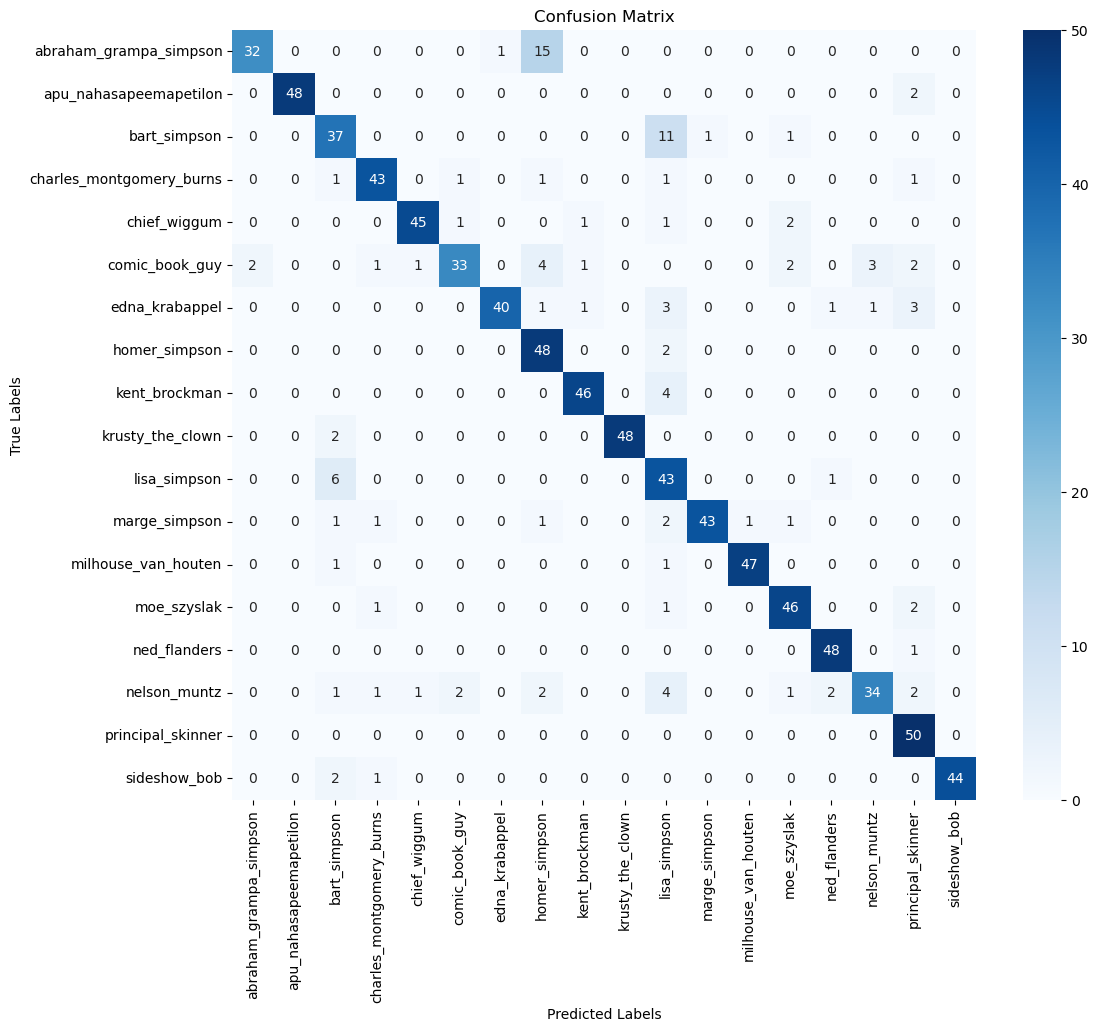

In [77]:
conf_matrix = confusion_matrix(np.argmax(true_labels, axis=1), predicted_labels)

class_labels = [map_characters[i] for i in range(len(map_characters))]

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [78]:
class_report = classification_report(np.argmax(true_labels, axis=1), predicted_labels, target_names=class_labels)

print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.67      0.78        48
  apu_nahasapeemapetilon       1.00      0.96      0.98        50
            bart_simpson       0.73      0.74      0.73        50
charles_montgomery_burns       0.90      0.90      0.90        48
            chief_wiggum       0.96      0.90      0.93        50
          comic_book_guy       0.89      0.67      0.77        49
          edna_krabappel       0.98      0.80      0.88        50
           homer_simpson       0.67      0.96      0.79        50
           kent_brockman       0.94      0.92      0.93        50
        krusty_the_clown       1.00      0.96      0.98        50
            lisa_simpson       0.59      0.86      0.70        50
           marge_simpson       0.98      0.86      0.91        50
     milhouse_van_houten       0.98      0.96      0.97        49
             moe_szyslak       0.87      0.92      0.89        50
         

In [79]:
precision = precision_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels_one_hot)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.89
Recall: 0.87
F1-Score: 0.87
Accuracy: 0.87
